In [12]:
import os, sys
import pickle
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import cm
from matplotlib.patches import Arrow
from matplotlib.gridspec import GridSpec
from astropy.table import Table, Column, vstack
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


%load_ext autoreload
%autoreload 2

sys.path.append('/Users/belugawhale/Documents/GitHub/nirhiss/')
from src.nirhiss.plotting import ers_transmission_spectra
from src.nirhiss.juliet_utils import compile_posteriors
from src.nirhiss.utils import bin_at_resolution

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

parula = np.load('/Users/belugawhale/parula_colors.npy', allow_pickle=True)

halloween = LinearSegmentedColormap.from_list('halloween', ['#FFEFC9', '#FFC502','#DEB314','#b3ac27', 
                                                            '#91ae46', '#6c9654', '#5A7E5A', '#3e6d53', 
                                                            '#316454','#265C57','#602749', '#3D1C33', 
                                                            '#281324', '#130912'])

#color_list = ['#49af7f', '#ff9844', '#404040', '#b02e37', '#93648D', '#4ab9cc', '#ffb62f']
color_list = ['#FFEFC9', '#FFC502','#DEB314','#b3ac27', 
                                                            '#91ae46', '#6c9654', '#5A7E5A', '#3e6d53', 
                                                            '#316454','#265C57','#602749', '#3D1C33', 
                                                            '#281324', '#130912']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = Table.read('/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/ts/CMADF-WASP_39b_NIRISS_transmission_spectrum_R300.csv',
                  format='csv', comment='#')

In [3]:
def convolve_model(filename, R=300):
    model = np.loadtxt(filename)

    R0=3000.0 #cross-section resolution
    xker = np.arange(1000)-500
    sigma = (R0/R)/(2.* np.sqrt(2.0*np.log(2.0)))
    yker = np.exp(-0.5 * (xker / sigma)**2.0)
    yker /= yker.sum()
    model_to_plot=np.convolve(model[:,1],yker,mode='same') #convolving
    return model[:,0], model_to_plot

In [4]:
path = 'data/model_rule_out_co/'
co_files = np.sort([os.path.join(path, i) for i in os.listdir(path) if i.endswith('.txt')])

In [5]:
path = 'data/model_rule_out_z/'
z_files = np.sort([os.path.join(path, i) for i in os.listdir(path) if i.endswith('.txt')])
z_files = np.array(z_files)[np.array([0,2,4,5])]

In [6]:
ref_file = 'data/Main_Models/model_reference.txt'

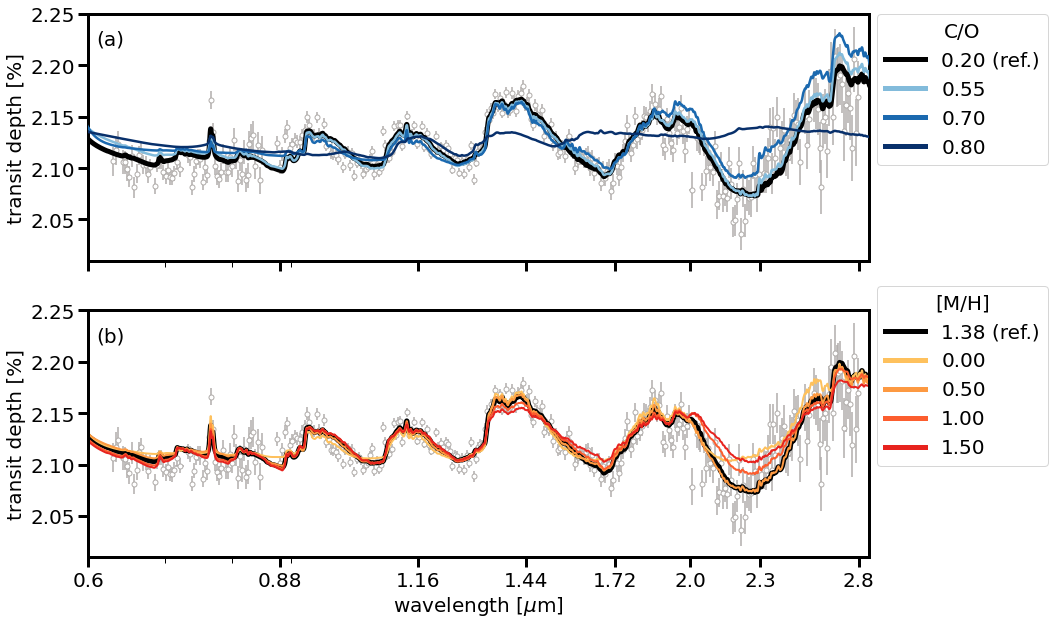

In [7]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14,10), sharex=True,
                              sharey=True)
fig.set_facecolor('w')

cutends = 15

for i, a in enumerate([ax1, ax2]):
    a.errorbar(data['wave'], data['dppm']/1e6, 
             xerr=data['wave_error'],
             yerr=data['dppm_err']/1e6,
             linestyle='', marker='o',
             markeredgecolor='#b0acaa',
             ecolor='#b0acaa',
             color='w', zorder=1)
    ref = convolve_model(ref_file)
    
    if i == 0:
        label = '0.20 (ref.)'
    else:
        label = '1.38 (ref.)'
        
    a.plot(ref[0][cutends:-cutends], ref[1][cutends:-cutends],
             label=label, lw=5,
             c='k', zorder=2)
        

co_norm = matplotlib.colors.Normalize(vmin=0.35, vmax=0.8)
z_norm = matplotlib.colors.Normalize(vmin=-1.2, vmax=2.5)

co_vals = [0.55, 0.70, 0.80]
c = ['#24abff', '#1f88c9', '#155d8a']
for i,fn in enumerate(co_files):
    model = convolve_model(fn)
    ax1.plot(model[0][cutends:-cutends], model[1][cutends:-cutends],
             label='{0:.2f}'.format(co_vals[i]), lw=2.5,
             c=cm.Blues(co_norm(co_vals[i])), zorder=10)

z_vals = [0.0, 0.5, 1.0, 1.5, 2.0, 2.25]
for i,fn in enumerate(z_files):
    model = convolve_model(fn)
    ax2.plot(model[0][cutends:-cutends], model[1][cutends:-cutends],
             label='{0:.2f}'.format(z_vals[i]), lw=2,
             c=cm.YlOrRd(z_norm(z_vals[i])))

plt.xlim(0.6,2.86)
ax2.set_xlabel('wavelength [$\mu$m]')
ax1.set_ylabel('transit depth [%]')
ax2.set_ylabel('transit depth [%]')
plt.xscale('log')
xticks = np.append(np.linspace(0.6,2,6), np.linspace(2.3,2.8,2))
xticks = np.round(xticks,2)
plt.xticks(xticks, labels=np.round(xticks,2))

yticks = np.round(np.arange(0.0205, 0.0230, 0.0005),4)
ax1.set_yticks(yticks)
labels = np.round(yticks*100,2)
labels = [format(i, '.2f') for i in labels]
ax1.set_yticklabels(labels)

ax1.text(s='(a)', x=0.61, y=0.0222, fontsize=20)
ax2.text(s='(b)', x=0.61, y=0.0222, fontsize=20)


leg = ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title='C/O')
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
    
leg = ax2.legend(bbox_to_anchor=(1.01, 1.1), loc=2, borderaxespad=0., title='[M/H]')
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
    
#plt.savefig('/Users/belugawhale/Desktop/co_metallicity.png',
#           dpi=300, rasterize=True, bbox_inches='tight')
    
#plt.savefig('/Users/belugawhale/Documents/niriss_real/wasp39/paper_figures/co_metallicity.pdf',
#           dpi=300, rasterize=True, bbox_inches='tight')

['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']

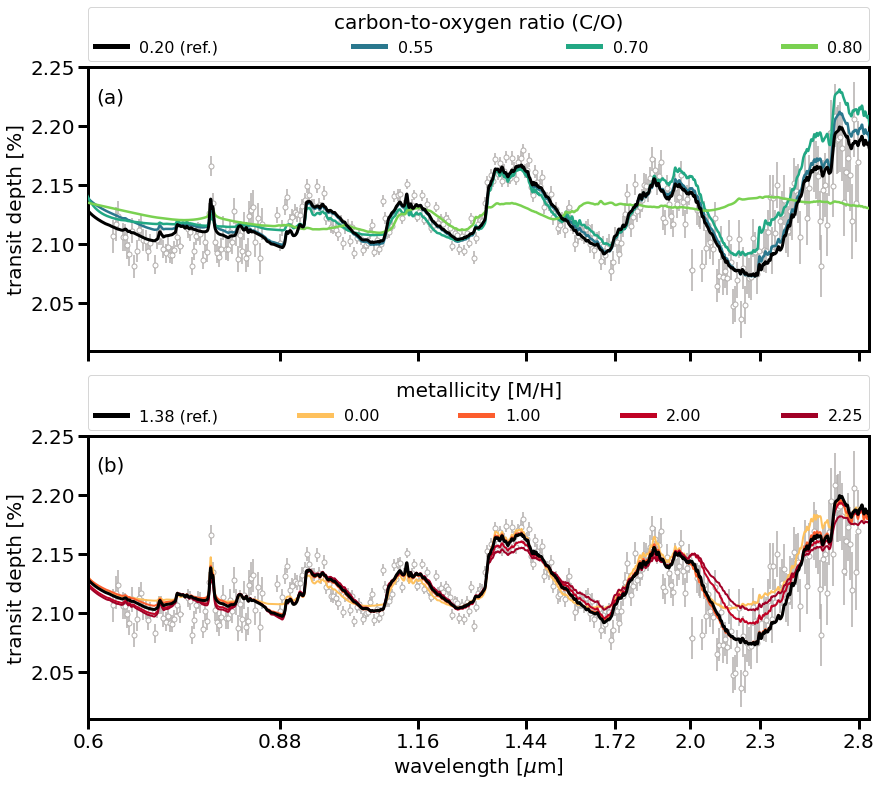

In [69]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14,12), sharex=True,
                              sharey=True)
fig.set_facecolor('w')

cutends = 15

for i, a in enumerate([ax1, ax2]):
    a.errorbar(data['wave'], data['dppm']/1e6, 
             xerr=data['wave_error'],
             yerr=data['dppm_err']/1e6,
             linestyle='', marker='o',
             markeredgecolor='#b3afad',
             ecolor='#b3afad',
             color='w', zorder=1)
    ref = convolve_model(ref_file)
    
    if i == 0:
        label = '0.20 (ref.)'
    else:
        label = '1.38 (ref.)'
        
    a.plot(ref[0][cutends:-cutends], ref[1][cutends:-cutends],
             label=label, lw=3,
             c=COLOR, zorder=20)
        

co_norm = matplotlib.colors.Normalize(vmin=0.4, vmax=0.9)
z_norm = matplotlib.colors.Normalize(vmin=-1.2, vmax=2.5)

co_vals = [0.55, 0.70, 0.80]
vals = [0.6, 0.7, 0.8]
c = ['#24abff', '#1f88c9', '#155d8a']

for i,fn in enumerate(co_files):
    model = convolve_model(fn)
    ax1.plot(model[0][cutends:-cutends], model[1][cutends:-cutends],
             label='{0:.2f}'.format(co_vals[i]), lw=2.5,
             c=cm.viridis(co_norm(vals[i])), 
             zorder=10)

z_vals = [0.0, 0.5, 1.0, 1.5, 2.0, 2.25]
z_vals = [0.0, 1.0, 2.0, 2.25]
for i,fn in enumerate(z_files):
    model = convolve_model(fn)
    ax2.plot(model[0][cutends:-cutends], model[1][cutends:-cutends],
             label='{0:.2f}'.format(z_vals[i]), lw=2,
             c=cm.YlOrRd(z_norm(z_vals[i])))

plt.xlim(0.6,2.86)
ax2.set_xlabel('wavelength [$\mu$m]')
ax1.set_ylabel('transit depth [%]')
ax2.set_ylabel('transit depth [%]')
plt.xscale('log')
xticks = np.append(np.linspace(0.6,2,6), np.linspace(2.3,2.8,2))
xticks = np.round(xticks,2)
plt.xticks(xticks, labels=np.round(xticks,2))

yticks = np.round(np.arange(0.0205, 0.0230, 0.0005),4)
ax1.set_yticks(yticks)
labels = np.round(yticks*100,2)
labels = [format(i, '.2f') for i in labels]
ax1.set_yticklabels(labels)

ax1.text(s='(a)', x=0.61, y=0.0222, fontsize=20)
ax2.text(s='(b)', x=0.61, y=0.0222, fontsize=20)


leg = ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=4, mode="expand", borderaxespad=0., 
                 fontsize=16, title='carbon-to-oxygen ratio (C/O)')
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
    
leg = ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=7, mode="expand", borderaxespad=0., 
                 fontsize=16, title='metallicity [M/H]')
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
    
plt.minorticks_off()
    
plt.subplots_adjust(hspace=0.3)
    
plt.savefig('/Users/belugawhale/Documents/niriss_real/wasp39/paper_figures/co_metallicity.pdf',
            #'/Users/belugawhale/Desktop/co_metallicity.png',
               dpi=300, rasterize=True, bbox_inches='tight')

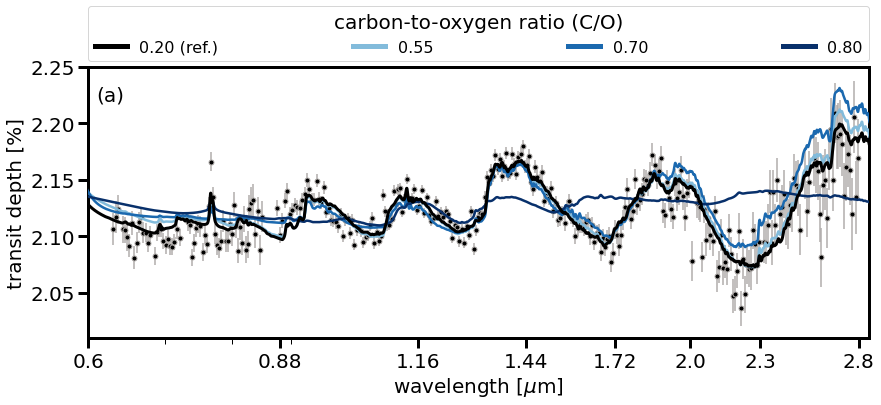

In [65]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(14,5), sharex=True,
                              sharey=True)
#fig.set_facecolor('w')

cutends = 15

for i, a in enumerate([ax1]):
    a.errorbar(data['wave'], data['dppm']/1e6, 
             xerr=data['wave_error'],
             yerr=data['dppm_err']/1e6,
             linestyle='', marker='o',
             markeredgecolor='#b0acaa',
             ecolor='#b0acaa',
             color='k', zorder=1)
    ref = convolve_model(ref_file)
    
    if i == 0:
        label = '0.20 (ref.)'
    else:
        label = '1.38 (ref.)'
        
    a.plot(ref[0][cutends:-cutends], ref[1][cutends:-cutends],
             label=label, lw=3,
             c=COLOR, zorder=20)
        

co_norm = matplotlib.colors.Normalize(vmin=0.35, vmax=0.8)
z_norm = matplotlib.colors.Normalize(vmin=-1.2, vmax=2.5)

co_vals = [0.55, 0.70, 0.80]
c = ['#24abff', '#1f88c9', '#155d8a']
for i,fn in enumerate(co_files):
    model = convolve_model(fn)
    ax1.plot(model[0][cutends:-cutends], model[1][cutends:-cutends],
             label='{0:.2f}'.format(co_vals[i]), lw=2.5,
             c=cm.Blues(co_norm(co_vals[i])), zorder=10)

z_vals = [0.0, 0.5, 1.0, 1.5, 2.0, 2.25]
z_vals = [0.0, 1.0, 2.0, 2.25]
for i,fn in enumerate(z_files):
    model = convolve_model(fn)
    ax2.plot(model[0][cutends:-cutends], model[1][cutends:-cutends],
             label='{0:.2f}'.format(z_vals[i]), lw=2,
             c=cm.YlOrRd(z_norm(z_vals[i])))

plt.xlim(0.6,2.86)
ax1.set_xlabel('wavelength [$\mu$m]')
ax1.set_ylabel('transit depth [%]')
#ax2.set_ylabel('transit depth [%]')
plt.xscale('log')
xticks = np.append(np.linspace(0.6,2,6), np.linspace(2.3,2.8,2))
xticks = np.round(xticks,2)
plt.xticks(xticks, labels=np.round(xticks,2))

yticks = np.round(np.arange(0.0205, 0.0230, 0.0005),4)
ax1.set_yticks(yticks)
labels = np.round(yticks*100,2)
labels = [format(i, '.2f') for i in labels]
ax1.set_yticklabels(labels)

ax1.text(s='(a)', x=0.61, y=0.0222, fontsize=20)
ax2.text(s='(b)', x=0.61, y=0.0222, fontsize=20)


leg = ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=4, mode="expand", borderaxespad=0., 
                 fontsize=16, title='carbon-to-oxygen ratio (C/O)')
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
    
#leg = ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#                 ncol=7, mode="expand", borderaxespad=0., 
#                 fontsize=16, title='metallicity [M/H]')
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(5.0)
    
plt.subplots_adjust(hspace=0.43)
    
plt.savefig(#'/Users/belugawhale/Documents/niriss_real/wasp39/paper_figures/co_metallicity.pdf',
            '/Users/belugawhale/Desktop/co.png',
           dpi=300, rasterize=True, bbox_inches='tight', transparent=True)

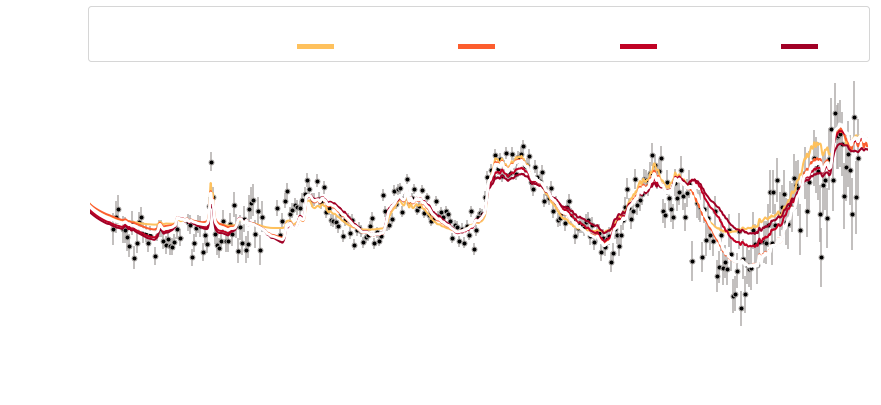

In [19]:
fig, (ax2) = plt.subplots(nrows=1, figsize=(14,5), sharex=True,
                              sharey=True)
#fig.set_facecolor('w')

cutends = 15

for i, a in enumerate([ax2]):
    a.errorbar(data['wave'], data['dppm']/1e6, 
             xerr=data['wave_error'],
             yerr=data['dppm_err']/1e6,
             linestyle='', marker='o',
             markeredgecolor='#b0acaa',
             ecolor='#b0acaa',
             color='k', zorder=1)
    ref = convolve_model(ref_file)
    
    if i == 0:
        label = '0.20 (ref.)'
    else:
        label = '1.38 (ref.)'
        
    a.plot(ref[0][cutends:-cutends], ref[1][cutends:-cutends],
             label=label, lw=3,
             c=COLOR, zorder=20)
        

co_norm = matplotlib.colors.Normalize(vmin=0.35, vmax=0.8)
z_norm = matplotlib.colors.Normalize(vmin=-1.2, vmax=2.5)

co_vals = [0.55, 0.70, 0.80]
c = ['#24abff', '#1f88c9', '#155d8a']
for i,fn in enumerate(co_files):
    model = convolve_model(fn)
    ax1.plot(model[0][cutends:-cutends], model[1][cutends:-cutends],
             label='{0:.2f}'.format(co_vals[i]), lw=2.5,
             c=cm.Blues(co_norm(co_vals[i])), zorder=10)

z_vals = [0.0, 0.5, 1.0, 1.5, 2.0, 2.25]
z_vals = [0.0, 1.0, 2.0, 2.25]
for i,fn in enumerate(z_files):
    model = convolve_model(fn)
    ax2.plot(model[0][cutends:-cutends], model[1][cutends:-cutends],
             label='{0:.2f}'.format(z_vals[i]), lw=2,
             c=cm.YlOrRd(z_norm(z_vals[i])))

plt.xlim(0.6,2.86)
ax2.set_xlabel('wavelength [$\mu$m]')
ax2.set_ylabel('transit depth [%]')
#ax2.set_ylabel('transit depth [%]')
plt.xscale('log')
xticks = np.append(np.linspace(0.6,2,6), np.linspace(2.3,2.8,2))
xticks = np.round(xticks,2)
ax2.set_xticks(xticks)
ax2.set_xticklabels(np.round(xticks,2))

yticks = np.round(np.arange(0.0205, 0.0230, 0.0005),4)
ax2.set_yticks(yticks)
labels = np.round(yticks*100,2)
labels = [format(i, '.2f') for i in labels]
ax2.set_yticklabels(labels)

ax1.text(s='(a)', x=0.61, y=0.0222, fontsize=20)
ax2.text(s='(b)', x=0.61, y=0.0222, fontsize=20)


#leg = ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#                 ncol=4, mode="expand", borderaxespad=0., 
#                 fontsize=16, title='carbon-to-oxygen ratio (C/O)')
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(5.0)
    
leg = ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=7, mode="expand", borderaxespad=0., 
                 fontsize=16, title='metallicity [M/H]')
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
    
plt.subplots_adjust(hspace=0.43)
    
plt.savefig(#'/Users/belugawhale/Documents/niriss_real/wasp39/paper_figures/co_metallicity.pdf',
            '/Users/belugawhale/Desktop/metallicity.png',
           dpi=300, rasterize=True, bbox_inches='tight', transparent=True)